In [24]:
import keras

from keras.utils import np_utils

In [54]:
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, merge, Input
from keras.layers import Convolution2D, Convolution3D, MaxPooling2D, UpSampling2D, ZeroPadding2D

In [14]:
import dicom
import fnmatch
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy.misc.pilutil import imresize

In [93]:
BATCH_SIZE = 5
CLASSES_NUM = 10
EPOCH_NUM = 100
X_IMAGE_SIZE = 286
# It should be computed according to CNN architecture
Y_IMAGE_SIZE = 240
TRAIN_DIR = '../rib_detection/data/train'
TEST_DIR = '../rib_detection/data/validate'

In [88]:
X_train = []
Y_train = []
X_test = []
Y_test = []

for directory, x_arr, y_arr in zip([TRAIN_DIR, TEST_DIR], [X_train, X_test], [Y_train, Y_test]):
    dcm_images = sorted([os.path.join(path, f)
                                     for path, _, files in os.walk(directory)
                                     for f in fnmatch.filter(files, 'image*.dcm')])

    dcm_labels = sorted([os.path.join(path, f)
                         for path, _, files in os.walk(directory)
                         for f in fnmatch.filter(files, 'ribsMask*.dcm')])

    for img, lbl in zip(dcm_images, dcm_labels):
        x_arr.append(imresize(dicom.read_file(img).pixel_array, [X_IMAGE_SIZE, X_IMAGE_SIZE]))
        y_arr.append(imresize(dicom.read_file(lbl).pixel_array, [Y_IMAGE_SIZE, Y_IMAGE_SIZE]))
        
X_train  = np.expand_dims(np.array(X_train, dtype=np.float32), 1) / 255
Y_train  = np.expand_dims(np.array(Y_train, dtype=np.float32), 1) / 255

X_test  = np.expand_dims(np.array(X_test, dtype=np.float32), 1) / 255
Y_test  = np.expand_dims(np.array(Y_test, dtype=np.float32), 1) / 255

0.99607843

In [89]:
print('X_train shape: %s' % (X_train.shape, ))
print('y_train shape: %s' % (Y_train.shape, ))
print('X_test shape: %s' % (X_test.shape, ))
print('y_test shape: %s' % (Y_test.shape, ))

X_train shape: (30, 1, 286, 286)
y_train shape: (30, 1, 240, 240)
X_test shape: (10, 1, 286, 286)
y_test shape: (10, 1, 240, 240)


In [119]:
main_input = Input(shape=(1, X_IMAGE_SIZE, X_IMAGE_SIZE))

convolution_1_1 = Convolution2D(8, 3, 3, input_shape=X_train.shape, activation='relu')(main_input)
convolution_1_2 = Convolution2D(16, 3, 3, activation='relu')(convolution_1_1)
pool_1 = MaxPooling2D(pool_size=(2, 2))(convolition_1_2)

convolution_2_1 = Convolution2D(16, 3, 3, activation='relu')(pool_1)
convolution_2_2 = Convolution2D(16, 3, 3, activation='relu')(convolution_2_1)
pool_2 = MaxPooling2D(pool_size=(2, 2))(convolution_2_2)

convolution_3_1 = Convolution2D(16, 3, 3, activation='relu')(pool_2)
convolution_3_2 = Convolution2D(16, 3, 3, activation='relu')(convolution_3_1)
pool_3 = MaxPooling2D(pool_size=(2, 2))(convolution_3_2)

convolution_4_1 = Convolution2D(16, 3, 3, activation='relu')(pool_3)
convolution_4_2 = Convolution2D(16, 3, 3, activation='relu')(convolution_4_1)
pool_4 = MaxPooling2D(pool_size=(2, 2))(convolution_4_2)

convolution_5_1 = Convolution2D(16, 3, 3, activation='relu')(pool_4)
convolution_5_2 = Convolution2D(16, 3, 3, activation='relu')(convolution_5_1)

first_upsampled = UpSampling2D(size=(2, 2))(convolution_5_2)
# second_cropped = ZeroPadding2D((-4, -4))(convolution_4_2)
# first_merged = merge([first_upsampled, second_cropped], mode='concat', concat_axis=1)
convolution_6_1 = Convolution2D(16, 3, 3, activation='relu')(first_upsampled)
convolution_6_2 = Convolution2D(16, 3, 3, activation='relu')(convolution_6_1)

second_upsampled = UpSampling2D(size=(2, 2))(convolution_6_2)
# first_cropped = ZeroPadding2D((-18, -18))(convolition_1_3)
# second_merged = merge([second_upsampled, first_cropped], mode='concat', concat_axis=1)
convolution_7_1 = Convolution2D(16, 3, 3, activation='relu')(second_upsampled)
convolution_7_2 = Convolution2D(16, 3, 3, activation='relu')(convolution_7_1)

third_upsampled = UpSampling2D(size=(2, 2))(convolution_7_2)
convolution_8_1 = Convolution2D(16, 3, 3, activation='relu')(third_upsampled)
convolution_8_2 = Convolution2D(16, 3, 3, activation='relu')(convolution_8_1)

fourth_upsampled = UpSampling2D(size=(2, 2))(convolution_6_2)
convolution_9_1 = Convolution2D(16, 3, 3, activation='relu')(fourth_upsampled)
convolution_9_2 = Convolution2D(16, 3, 3, activation='relu')(convolution_9_1)

convolution_10_1 = Convolution2D(1, 1, 1, activation='sigmoid')(convolution_9_2)

In [118]:
print(model.layers[7].output_shape)
print(model.layers[11].output_shape)
print(model.layers[12].output_shape)

(None, 16, 134, 134)
(None, 16, 126, 126)
(None, 16, 126, 126)


In [120]:
model = Model(input=main_input, output=convolution_6_1)
model.compile(optimizer='rmsprop', loss='binary_crossentropy')

hist = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, nb_epoch=EPOCH_NUM,
          verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

INFO (theano.gof.compilelock): Refreshing lock /home/fonturacetamum/.theano/compiledir_Linux-3.19--generic-x86_64-with-debian-jessie-sid-x86_64-3.5.1-64/lock_dir/lock


Train on 30 samples, validate on 10 samples
Epoch 1/100
30/30 [==============================] - 19s - loss: 0.6833 - val_loss: 0.6524
Epoch 2/100
30/30 [==============================] - 16s - loss: 0.5628 - val_loss: 0.4850
Epoch 3/100
30/30 [==============================] - 16s - loss: 0.4891 - val_loss: 0.4864
Epoch 4/100
30/30 [==============================] - 16s - loss: 0.4693 - val_loss: 0.4397
Epoch 5/100
30/30 [==============================] - 16s - loss: 0.4519 - val_loss: 0.4097
Epoch 6/100
30/30 [==============================] - 16s - loss: 0.4307 - val_loss: 0.3818
Epoch 7/100
30/30 [==============================] - 23s - loss: 0.3911 - val_loss: 0.3677
Epoch 8/100
30/30 [==============================] - 18s - loss: 0.3971 - val_loss: 0.3607
Epoch 9/100
30/30 [==============================] - 16s - loss: 0.3968 - val_loss: 0.3719
Epoch 10/100
30/30 [==============================] - 16s - loss: 0.3966 - val_loss: 0.4049
Epoch 11/100
30/30 [=========================

IndexError: invalid index to scalar variable.

model

0.347276479006


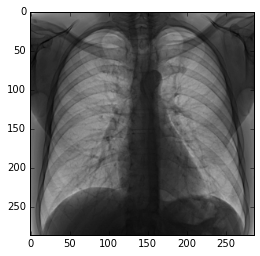

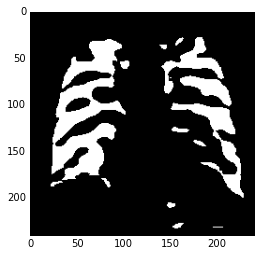

In [133]:
%matplotlib inline
print(score)
plt.set_cmap('gray')
plt.figure()
plt.imshow(X_train[0][0])
plt.figure()
plt.imshow(model.predict(np.expand_dims(X_train[1], 0))[0][0] > 0.5)
# plt.imshow(X_train[0].transpose([1, 2, 0]))
# print(y_train[0])

(1, 8, 28, 28)


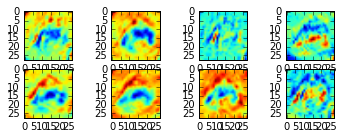

In [89]:
from keras import backend as K

# with a Sequential model
get_layer_output = K.function([model.layers[0].input],
                                  [model.layers[0].output])
layer_output = get_layer_output([np.expand_dims(X_train[0], axis=0)])[0]
print(layer_output.shape)

for i in range(8):
    plt.subplot(4, 4, i+1)
    plt.imshow(layer_output[0][i])